In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import random

In [3]:
import json
import torch
!pip install sentencepiece
!pip install transformers
import warnings
warnings.filterwarnings('ignore')
from transformers import XLMRobertaTokenizer, XLMRobertaModel, XLMRobertaConfig, AdamW
import pandas as pd
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

     |████████████████████████████████| 1.2 MB 5.3 MB/s 
     |████████████████████████████████| 2.9 MB 5.4 MB/s 
     |████████████████████████████████| 3.3 MB 36.3 MB/s 
     |████████████████████████████████| 596 kB 44.3 MB/s 
     |████████████████████████████████| 56 kB 4.4 MB/s 
     |████████████████████████████████| 895 kB 37.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [5]:
expt_folder = "drive/MyDrive/"

In [6]:
o_df = pd.read_csv(expt_folder + 'clickbait_data.csv')
df=o_df.sample(frac=0.8,random_state=42) #random state is a seed value
test_df=o_df.drop(df.index)

In [7]:
# Get the lists of sentences and their labels.
headlines = df.headline.values
labels = df.clickbait.values

In [8]:
# Download the tokenizer for the XLM-Robert `base` model.
XLM_Tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base" )
XLM_Model = XLMRobertaModel.from_pretrained('xlm-roberta-base')

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/512 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
# Print the original sentence.
print(' Original: ', headlines[0])

# Print the sentence split into tokens.
print('Tokenized: ', XLM_Tokenizer.tokenize(headlines[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', XLM_Tokenizer.convert_tokens_to_ids(XLM_Tokenizer.tokenize(headlines[0])))

 Original:  Filipino activist arrested for disrupting Manila Cathedral mass in Reproductive Health Bill protest
Tokenized:  ['▁Filipino', '▁activist', '▁arrest', 'ed', '▁for', '▁disrupt', 'ing', '▁Manila', '▁Cathedral', '▁mass', '▁in', '▁Reprodu', 'c', 'tive', '▁Health', '▁Bill', '▁protest']
Token IDs:  [139510, 177500, 34784, 297, 100, 226586, 214, 109047, 234120, 46889, 23, 176730, 238, 4935, 19102, 19893, 18782]


In [10]:
def get_BERT_input(headlines, tokenizer):
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []
  encoded_dict = tokenizer.batch_encode_plus(
                      headlines,                      # Sentence to encode.
                      add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                      max_length = 65,           # Pad & truncate all sentences.
                      pad_to_max_length = True,
                      return_attention_mask = True,   # Construct attn. masks.
                      return_tensors = 'pt',     # Return pytorch tensors.
                )
  input_ids, attention_mask = encoded_dict['input_ids'], encoded_dict['attention_mask']

  # Add the encoded sentence to the list.    
  input_ids = encoded_dict['input_ids']
  
  # And its attention mask (simply differentiates padding from non-padding).
  attention_mask = encoded_dict['attention_mask']

  return torch.tensor(input_ids), torch.tensor(attention_mask)

In [11]:
input_ids, attention_mask = get_BERT_input(headlines, XLM_Tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [12]:
# # Print sentence 0, now as a list of IDs.
# print(headlines[3])
# print('Original: ', headlines[3])
# print('Token IDs:', input_ids[3])
# print('Attention:', attention_mask[3])

In [13]:
input_ids, attention_mask = get_BERT_input(["նցող մարդը կարող է վերցնել այն, ինչ նետում է իր ճանապարհը սենդվիչ"], XLM_Tokenizer)
result = XLM_Model(input_ids, attention_mask=attention_mask,return_dict=True)
# result.last_hidden_state.shape

Model

In [14]:
import torch
import torch.nn as nn
class ClickbaitDetectorModel(nn.Module):
    """ClickbaitDetectorModel

    Args:
        word_vectors (torch.Tensor): Pre-trained word vectors.
        hidden_size (int): Number of features in the hidden state at each layer.
        drop_prob (float): Dropout probability.
    """
    def __init__(self):
        super(ClickbaitDetectorModel, self).__init__()
        # self.device = device
        self.XLM = XLMRobertaModel.from_pretrained('xlm-roberta-base', output_hidden_states=True)
        self.ffnn_nodes = 32
        # Converts tensor from size (b, max_len, 768) to (b, max_len, whatever size you choose)
        self.layer_1 = nn.Linear(768, self.ffnn_nodes)
        self.layer_2 = nn.Linear(self.ffnn_nodes, 2)
        self.softmax = nn.Softmax()
        # self.log_softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
      # print(sentence)
      # print(input_ids)
      bert_output = self.XLM(input_ids, attention_mask)
      hidden_state = bert_output['hidden_states'][-2]
      # print(hidden_state.shape)
      sentence_vector = torch.mean(hidden_state, dim=1)
      # print(sentence_vector.shape)
      # 
      start_ffnn_output = self.layer_2(self.layer_1(sentence_vector)).squeeze()
      # print(start_ffnn_output.shape)
      probability = self.softmax(start_ffnn_output)
      # print(probability)
      # So that after passing through softmax, they result in zero probability
      return probability

model = ClickbaitDetectorModel()
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base" )
# Comment below line if do not have saved model
# model.load_state_dict(torch.load(expt_folder + "ClickbaitModel.pt"))
model = model.to(device)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
input_ids, attention_mask = get_BERT_input(["This is a sentence", "This is not a sentence", "This is a sentence", "Bro is a sentence", "This is a question"], XLM_Tokenizer)
probability = model(input_ids.to(device), attention_mask.to(device))
print(probability)

tensor([[0.4058, 0.5942],
        [0.4084, 0.5916],
        [0.4058, 0.5942],
        [0.4104, 0.5896],
        [0.4060, 0.5940]], device='cuda:0', grad_fn=<SoftmaxBackward>)


Preprocess Dataset for Loss

In [16]:
df['model_truth_values'] = df['clickbait'].apply(lambda x: [0,1] if x else [1,0])
# df
model_truth_values = df['model_truth_values']
# model_truth_values
# df

In [17]:
class ClickbaitDataset(Dataset):
  def __init__(self, df):
    self.headlines = df['headline']
    self.model_truth_values = df['model_truth_values']
  
  def __len__(self):
    return len(self.headlines)
    
  def __getitem__(self, idx):
    return self.headlines.iloc[idx], torch.tensor(self.model_truth_values.iloc[idx]).float()

dataset = ClickbaitDataset(df)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)

In [18]:
dataset[0]

('Filipino activist arrested for disrupting Manila Cathedral mass in Reproductive Health Bill protest',
 tensor([1., 0.]))

Training Loop

In [19]:
loss_function = nn.BCELoss().to(device)
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

old_count = 0

loss_vals =  []
all_loss_vals = []
for epoch in range(0,1):
  epoch_loss= []
  print("Starting Epoch:", epoch + 1)
  for i_batch, (b_headline, b_model_truth_value) in enumerate(dataloader):
    optimizer.zero_grad()
    b_input_ids, b_attention_mask = get_BERT_input(b_headline, tokenizer)
    b_predictions = model(b_input_ids.to(device), b_attention_mask.to(device))
    loss = loss_function(b_predictions, b_model_truth_value.to(device))
    epoch_loss.append(loss.data.item())
    all_loss_vals.append(loss.data.item())
    if i_batch % 10 == 0:
      iteration = i_batch*batch_size
      print("Iteration:", i_batch*batch_size, "Loss:", loss.data)
      batch_accuracy = torch.mean(torch.sum(b_predictions * b_model_truth_value.to(device), dim=1))
      print("Batch Accuracy:", batch_accuracy.data*100)
      if iteration % 5120 == 0:
        # torch.save(model.state_dict(), expt_folder + "ClickbaitModel.pt")
        print("Saved Model")
      # rolling_accuracy = rolling_accuracy*old_count + 
    loss_vals.append(sum(epoch_loss)/len(epoch_loss))
    model.zero_grad()
    loss.backward()
    optimizer.step()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Starting Epoch: 1
Iteration: 0 Loss: tensor(0.6704, device='cuda:0')
Batch Accuracy: tensor(51.7770, device='cuda:0')
Saved Model
Iteration: 320 Loss: tensor(0.4117, device='cuda:0')
Batch Accuracy: tensor(67.8710, device='cuda:0')
Iteration: 640 Loss: tensor(0.3434, device='cuda:0')
Batch Accuracy: tensor(77.9240, device='cuda:0')
Iteration: 960 Loss: tensor(0.0285, device='cuda:0')
Batch Accuracy: tensor(97.2915, device='cuda:0')
Iteration: 1280 Loss: tensor(0.0889, device='cuda:0')
Batch Accuracy: tensor(95.4642, device='cuda:0')
Iteration: 1600 Loss: tensor(0.0532, device='cuda:0')
Batch Accuracy: tensor(95.4154, device='cuda:0')
Iteration: 1920 Loss: tensor(0.0516, device='cuda:0')
Batch Accuracy: tensor(95.8535, device='cuda:0')
Iteration: 2240 Loss: tensor(0.2178, device='cuda:0')
Batch Accuracy: tensor(92.7223, device='cuda:0')
Iteration: 2560 Loss: tensor(0.0055, device='cuda:0')
Batch Accuracy: tensor(99.4547, device='cuda:0')
Iteration: 2880 Loss: tensor(0.0793, device='cuda

In [20]:
torch.save(model.state_dict(), expt_folder + "ClickbaitModelwith32nodes.pt")

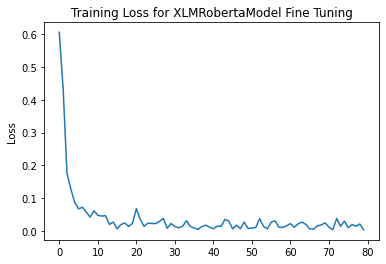

In [21]:
import matplotlib.pyplot as plt
import numpy as np
avg_loss = []

for i in range(0,len(all_loss_vals),10):
  avg_loss.append(sum(all_loss_vals[i:i+10])/10)

plt.title("Training Loss for XLMRobertaModel Fine Tuning")
plt.ylabel("Loss")
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(avg_loss)
plt.savefig(expt_folder + 'XLMRobertaModelLossGraph.png')

# Evaluation

In [22]:
eval_model = ClickbaitDetectorModel()
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base" )
eval_model.load_state_dict(torch.load(expt_folder + "ClickbaitModelwith32nodes.pt"))
eval_model.eval()
eval_model = eval_model.double().to(device)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
def predict(b_headline, tokenizer, model):
  b_input_ids, b_attention_mask = get_BERT_input(b_headline, tokenizer)
  b_predictions = model(b_input_ids.to(device), b_attention_mask.to(device))
  # predictions = []
  # print(b_predictions)
  # for prediction in b_predictions:
  #   predictions.append(prediction.data[1].item())
  return b_predictions.data[1].item()

# from torch import nn
softmax = nn.Softmax(dim=1)

def predict_class(b_headline, tokenizer, model):
  b_input_ids, b_attention_mask = get_BERT_input(b_headline, tokenizer)
  b_predictions = model(b_input_ids.to(device), b_attention_mask.to(device))
  print(b_predictions)
  return 1 if b_predictions.data[1].item()>b_predictions.data[0].item() else 0



In [39]:
predict(["Watch what this senator did yesterday"], tokenizer, eval_model)

0.6142066267782876

In [34]:
test_headlines = test_df.headline.values
test_labels = test_df.clickbait.values

predictions = []

for headline in test_headlines:
  pred = predict_class([headline], tokenizer, model)
  predictions.append(pred)

Streaming output truncated to the last 5000 lines.
tensor([1.8743e-04, 9.9981e-01], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([0.0014, 0.9986], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([2.0901e-04, 9.9979e-01], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([1.5847e-04, 9.9984e-01], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([1.8744e-04, 9.9981e-01], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([2.3905e-04, 9.9976e-01], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([1.1662e-04, 9.9988e-01], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([4.2137e-04, 9.9958e-01], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([0.0041, 0.9959], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([3.3768e-04, 9.9966e-01], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([1.4180e-04, 9.9986e-01], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([1.3832e-04, 9.9986e-01], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([1.3175e-04, 9.9987e-01], device='

In [35]:
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score 

print("Testing size:", len(predictions))
acc=accuracy_score(predictions,test_labels)
f1=f1_score(predictions,test_labels)
precision=precision_score(predictions,test_labels)
recall=recall_score(predictions,test_labels)
print("--"*40)
print(" accuracy={} \n f1={} \n precision={} \n recall={}\n\n".format(acc,f1,precision,recall))
print("--"*40)

Testing size: 6400
--------------------------------------------------------------------------------
 accuracy=0.99625 
 f1=0.9961563100576554 
 precision=0.9990362993896563 
 recall=0.9932928776748643


--------------------------------------------------------------------------------


______END OF UPWORTHY HEADLINE DETECTION TRAINING____


In [37]:
upworthy_df = pd.read_csv("/content/drive/MyDrive/11packages.csv")

In [38]:
upworthy_df["click_rate"] = upworthy_df["clicks"] / upworthy_df["impressions"]

In [41]:
headlines = []
for headline in upworthy_df.headline:
  if type(headline)!=str:
    headlines.append("")
    continue
  headlines.append(headline)

set_headlines = set(headlines)
print("length o set", len(set_headlines))
headline_mapping = {}
for headline in set_headlines:
  headline_mapping[headline] = predict([headline], tokenizer, eval_model)


length o set 65363


In [42]:
upworthiness = []
for i in range(len(headlines)):
  if i%1000==0:
    print(i)
  upworthiness.append(headline_mapping[headlines[i]])

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000


In [43]:
upworthy_df["upworthiness"] = upworthiness

In [44]:
upworthy_df.to_csv("/content/drive/MyDrive/00FINAL_TRUEUpworthyWithUpworthinessColumn.csv",index=False)